In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import sys
import numpy as np
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

from importlib import reload
sys.path.append("D:/DST/")
import cathay_db as db
import utils as ut
import financial_statement as fs

reload(ut)
reload(fs)
import matplotlib.pyplot as plt
import datetime
import os
import xgboost as xgb
sys.path.append("./src")

from toolbox import print_progress_bar

# set max display rows
pd.set_option("display.max_rows", 200)

# set max display columns
pd.set_option("display.max_columns", 100)

# Set the float format to display without scientific notation
pd.options.display.float_format = '{:.4f}'.format

In [2]:
df_price = pd.read_feather('data/cmoney_price.feather')
df_price = ut.cmoney_data_clean_up(df_price)
df_price = df_price[['日期','股票代號','收盤價']]
df_price.columns = ['date','ticker','unadj_price']
df_price['date'] = pd.to_datetime(df_price['date'])
# sort by date for shift
df_price.sort_values(['ticker','date'],inplace=True)
# shift to get last day price
df_price['yesterday_price'] = df_price.groupby('ticker')['unadj_price'].shift(1)
df_price['unadj_price'] = df_price['unadj_price'].astype(float)
df_price['yesterday_price'] = df_price['yesterday_price'].astype(float)

In [3]:
# select model 
model_folder_name = '20230713_141623'
# model_folder_name = '20230712_173216'
# model_folder_name = '20230711_171428'
# model_folder_name = '20230711_110457'
# model_folder_name = '20230707_140403'
# model_folder_name = '20230706_141045'

apply_buffer_index = 0
base_portfolio_number = 50
buffer_portfolio_number = 150

# model_folder_name = '20230706_141045'

# load setting from data/model/model_folder_name/setting.json
setting = ut.load_json(f'./data/model/{model_folder_name}/setting.json')

print(setting.keys())
print(setting['factor_columns'])



# df_dividend_select.to_feather(f'./data/model/{model_folder_name}/df_dividend_select.feather')
# df_dividend_select = pd.read_feather(f'./data/model/{model_folder_name}/df_dividend_select.feather')
df_dividend_select = pd.read_feather(f'./data/model/{model_folder_name}/df_buffer_result_{apply_buffer_index}_{base_portfolio_number}_{buffer_portfolio_number}.feather')

# load df_factor from data/model/model_folder_name/df_factor_all.feather
df_factor_all = pd.read_feather(f'./data/model/{model_folder_name}/df_factor_all_select.feather')

select_ticker = df_dividend_select['ticker'].unique()

df_cash_dividends = pd.read_feather('data/tej_cash_dividends.feather')
df_cash_dividends = ut.tej_data_clean_up(df_cash_dividends)
df_cash_dividends = df_cash_dividends[['股票代號','除息日','息值(元)']].copy()
df_cash_dividends.columns = ['ticker','date','dividend']
df_cash_dividends = df_cash_dividends[df_cash_dividends['ticker'].isin(select_ticker)].copy()
df_cash_dividends.drop_duplicates(inplace=True)
df_cash_dividends['dividend'] = df_cash_dividends['dividend'].astype(float)
df_cash_dividends = df_cash_dividends.groupby(['ticker','date']).sum().reset_index()

dict_keys(['start_index', 'rebalance_date_lst', 'factor_columns', 'target_cols', 'model_save_path', 'param_search', 'fit_params'])
['asset_qoq', 'asset_yoy', 'ppe_qoq', 'ppe_yoy', 'tobins_q', 'ni_4q_sum_qoq', 'ni_4q_sum_yoy', 'roe_4q_sum', 'roe_4q_sum_qoq', 'roe_4q_sum_yoy', 'opm', 'opm_qoq', 'opm_yoy', 'ocf_4q_sum / asset', 'ocf/asset_qoq', 'ocf/asset_yoy', '20_d_return', '40_d_return', '60_d_return', 'dividend_1Y_sum_yield_x', 'dividend_2Y_sum_yield_x', 'dividend_3Y_sum_yield_x', 'dividend_1Y_sum_yield_y', 'dividend_2Y_sum_yield_y', 'dividend_3Y_sum_yield_y', 'last_dividend_yield']


# 計算持有期間取得的現金股利率

In [4]:
df_factor_all_price = pd.merge(df_factor_all,df_price,on=['date','ticker'],how='left')

df_factor_all_price_dividend = pd.merge(df_factor_all_price,df_cash_dividends,on=['date','ticker'],how='left')
df_factor_all_price_dividend['unadj_yield'] = df_factor_all_price_dividend['dividend'] / df_factor_all_price_dividend['yesterday_price']

# calculate the sum of dividend yield of each stock in each period 
df_period_yield = df_factor_all_price_dividend.groupby(['ticker','rebalance_date'], as_index=False, group_keys=False)['unadj_yield'].sum()

# merge the sum of dividend yield to df_dividend_select for calculate the portfolio dividend yield
df_dividend_select_yield = pd.merge(df_dividend_select,df_period_yield,on=['ticker','rebalance_date'],how='left')

df_quaterly_div = df_dividend_select_yield.groupby('rebalance_date')['unadj_yield'].mean().reset_index()
df_quaterly_div['year'] = df_quaterly_div['rebalance_date'].dt.year
df_quaterly_div.groupby('year')['unadj_yield'].sum().reset_index()['unadj_yield'].describe().reset_index()

,index,unadj_yield
0,count,19.0000
1,mean,0.0996
2,std,0.0243
3,min,0.0693
4,25%,0.0820
5,50%,0.0965
6,75%,0.1039
7,max,0.1657


<Axes: xlabel='year'>

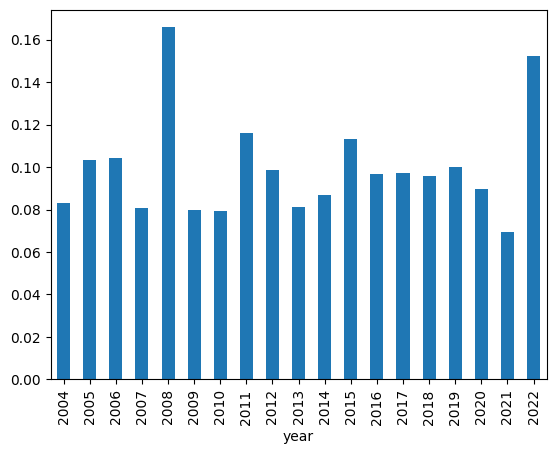

In [5]:
df_quaterly_div.groupby('year')['unadj_yield'].sum().plot(kind='bar')

# 計算選股 pct_rank 統計資料

In [6]:
# create pct_rank for y by date
df_factor_all['y_pct_rank'] = df_factor_all.groupby('date')['y'].rank(pct=True, ascending=False)
df_dividend_select = df_dividend_select.merge(df_factor_all[['ticker','date','y_pct_rank']],on=['ticker','date'],how='left')
df_dividend_select.groupby('date')['y_pct_rank'].describe().mean().reset_index()

,index,0
0,count,50.0000
1,mean,0.4939
2,std,0.2815
3,min,0.0250
4,25%,0.2557
5,50%,0.4919
6,75%,0.7293
7,max,0.9685


# 計算持有期間換倉的周轉率

In [7]:
# create the weight column for each ticker, weight = 1 / total num of ticker in the rebalance date
df_dividend_select_yield['weight'] = 1 / df_dividend_select_yield.groupby('rebalance_date')['ticker'].transform('count')

df_weight = pd.pivot(df_dividend_select_yield, index='rebalance_date', columns='ticker', values='weight').copy()
df_weight.fillna(0,inplace=True)

# calculate the turnover by calculate the abs change of weight and sum up
df_weight_change = df_weight.diff().abs() / 2 * 100
df_quarterly_turnover = df_weight_change.sum(axis=1).reset_index()
df_quarterly_turnover.columns = ['rebalance_date','turnover']
df_quarterly_turnover['year'] = df_quarterly_turnover['rebalance_date'].dt.year
df_yearly_turnover = df_quarterly_turnover.groupby('year')['turnover'].sum().reset_index()
df_yearly_turnover['turnover'].describe().reset_index()

,index,turnover
0,count,19.0000
1,mean,279.5789
2,std,23.6322
3,min,234.0000
4,25%,264.0000
5,50%,278.0000
6,75%,293.0000
7,max,322.0000
